In [1]:
from PIL import Image, ImageCms
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, savgol_filter

In [2]:
def load_image_as_lab(image_path):
    # Load the image
    image = Image.open(image_path)

    # Convert the image to the CIELAB color space
    srgb_profile = ImageCms.createProfile("sRGB")
    lab_profile = ImageCms.createProfile("LAB")
    transform = ImageCms.buildTransformFromOpenProfiles(
        srgb_profile, lab_profile, "RGB", "LAB"
    )
    lab_image = ImageCms.applyTransform(image, transform)

    return lab_image


def get_lightness_channel(lab_image):
    # Convert the image to a numpy array
    lab_array = np.array(lab_image)

    # Extract the lightness channel (L*)
    lightness_channel = lab_array[:, :, 0]

    return lightness_channel


def plot_lightness_channel(lightness_channel):
    # Create a 2D plot of the lightness channel
    plt.imshow(lightness_channel, cmap="gray", origin="upper")

    # Add a colorbar to show the lightness values
    plt.colorbar(label="Lightness (L*)")

    # Set the title and axis labels
    plt.title("Lightness Channel (L*)")
    plt.xlabel("x")
    plt.ylabel("y")

    # Show the plot
    plt.show()


def plot_peaks(data, peaks, widths):
    # Create a 1D plot of the data
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(data, label="Data")

    # Plot the detected peaks with markers
    ax.plot(peaks, data[peaks], "o", ms=8, mec="r", mfc="none", mew=2, label="Peaks")

    # Add labels for peak positions and widths
    for i, (peak, width) in enumerate(zip(peaks, widths)):
        ax.text(peak, data[peak], f"Peak {i+1}", ha="center", va="bottom")
        ax.text(peak, data[peak] / 2, f"Width: {width:.2f}", ha="center", va="top")

    # Set the title and axis labels
    plt.title("Absolute L* Profile Gradient with peaks")
    plt.xlabel("x")
    plt.ylabel("y")

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [20]:
%matplotlib widget

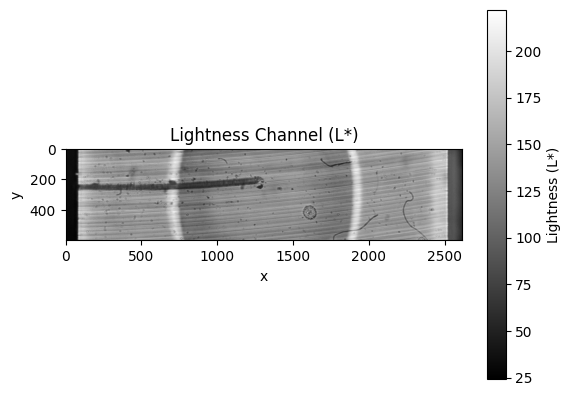

In [5]:
image_path = "../data/still_photos/EJ200PS-1X1P-5/FaceA/frame0.png"
lab_image = load_image_as_lab(image_path)
lightness_channel = get_lightness_channel(lab_image)
lightness_channel = np.pad(
    lightness_channel, ((0, 0), (100, 0)), mode="constant", constant_values=255
)
mid = int(lightness_channel.shape[0] / 2)
slc = [slice(mid - 300, mid + 300), slice(100, lightness_channel.shape[1])]
plot_lightness_channel(lightness_channel[*slc])

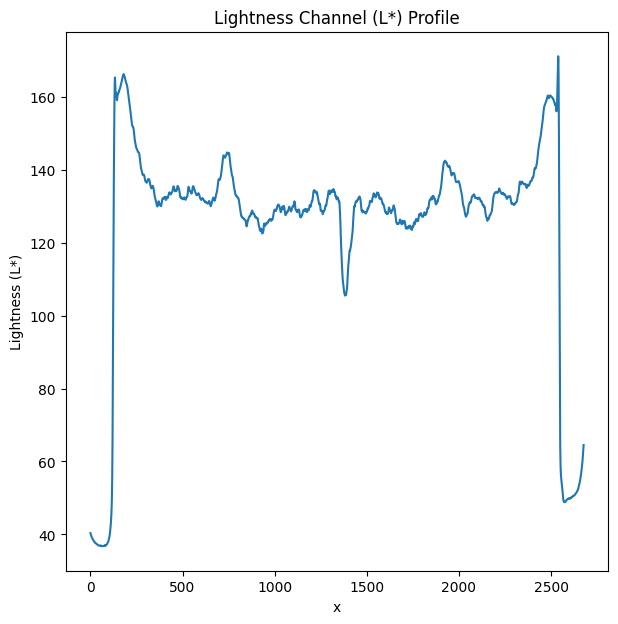

In [12]:
lightness_channel_profile_x = np.mean(lightness_channel, axis=0)
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(lightness_channel_profile_x)
plt.title("Lightness Channel (L*) Profile")
plt.xlabel("x")
plt.ylabel("Lightness (L*)")
plt.show()

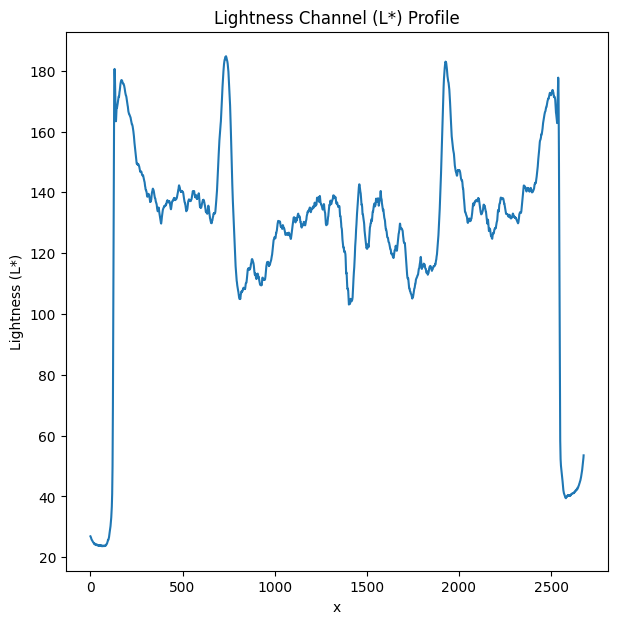

In [14]:
lightness_channel_profile_x_sliced = np.mean(lightness_channel[*slc], axis=0)
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(lightness_channel_profile_x_sliced)
plt.title("Lightness Channel (L*) Profile")
plt.xlabel("x")
plt.ylabel("Lightness (L*)")
plt.show()

124,  7.83
693,  22.78
766,  32.18
1385,  11.78
1435,  33.73
1907,  29.62
1956,  14.85
2545,  7.43


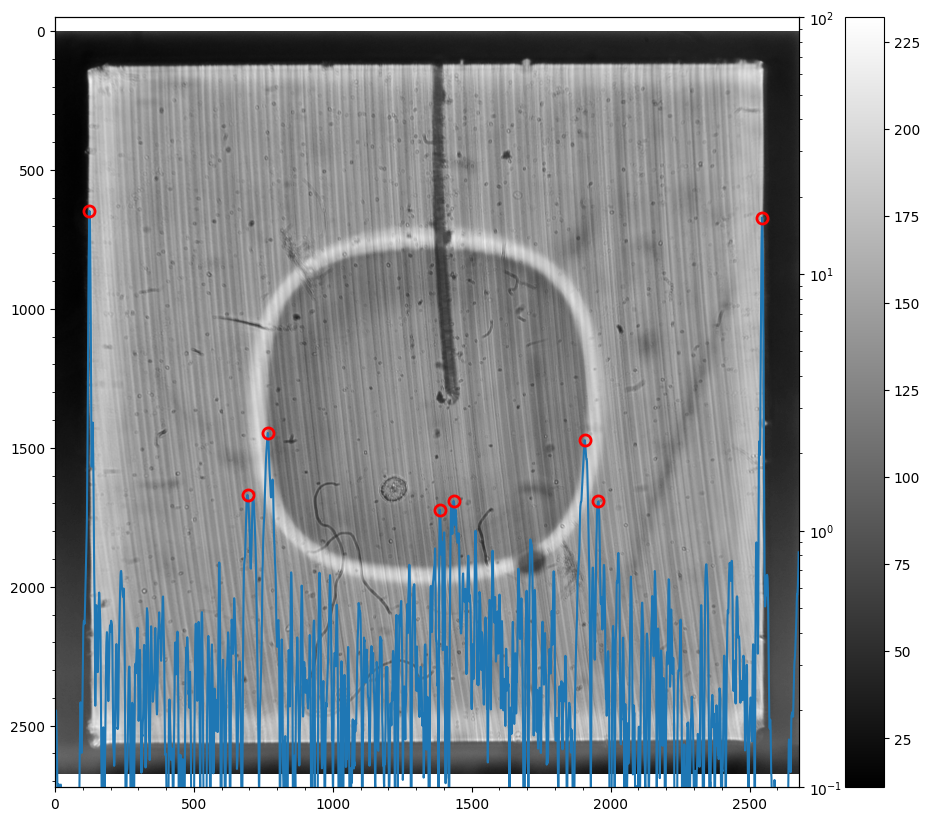

In [33]:
window = 11  # should be odd
polyorder = 3  # 3 looks okay unless you go with very small windows, however, the (3, 2) case doesn't make sense
cut = 300

mid = int(lightness_channel.shape[0] / 2)
slc = [slice(mid - cut, mid + cut), ...]

lightness_channel_profile_x_gradient = np.abs(
    np.gradient(np.mean(lightness_channel, axis=0))
)
lightness_channel_profile_x_gradient_cropped = np.abs(
    np.gradient(np.mean(lightness_channel[*slc], axis=0))
)
smoothened = savgol_filter(
    lightness_channel_profile_x_gradient, window_length=window, polyorder=polyorder
)
smoothened_cropped = savgol_filter(
    lightness_channel_profile_x_gradient_cropped,
    window_length=window,
    polyorder=polyorder,
)

fig, ax1 = plt.subplots(figsize=(12, 10))
im = ax1.imshow(lightness_channel, cmap="gray")
fig.colorbar(im, ax=ax1)

ax1.minorticks_on()

ax2 = ax1.twinx()
gradients = [
    # lightness_channel_profile_x_gradient,
    # lightness_channel_profile_x_gradient_cropped,
    # smoothened,
    smoothened_cropped,
]
for grd in gradients:
    peaks, _ = find_peaks(grd, prominence=1)
    widths, _, _, _ = peak_widths(grd, peaks, rel_height=0.5)
    # print(f"{grd=}")
    for i in range(len(peaks)):
        print(f"{peaks[i]}, {widths[i]: .2f}")
    ax2.plot(grd)
    ax2.plot(peaks, grd[peaks], "o", ms=8, mec="r", mfc="none", mew=2, label="Peaks")

ax2.set_yscale("log")
ax2.set_ylim(0.1, 100)
plt.show()

In [111]:
for window in [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]:
    for polyorder in [2, 3, 4, 5]:
        if polyorder >= window:
            continue
        smoothened = savgol_filter(
            lightness_channel_profile_x_gradient,
            window_length=window,
            polyorder=polyorder,
        )
        peaks, _ = find_peaks(smoothened, prominence=2)
        widths, _, _, _ = peak_widths(smoothened, peaks, rel_height=0.5)
        print(f"{window=}, {polyorder=}")
        print(f"\t{peaks=}")
        print(f"\t{widths=}")

window=3, polyorder=2
	peaks=array([ 316, 1143, 1156, 1204])
	widths=array([3.77025594, 5.66958829, 7.5966401 , 3.06580076])
window=5, polyorder=2
	peaks=array([ 316, 1143, 1155, 1204])
	widths=array([4.00238782, 5.48127717, 7.61353478, 3.39545868])
window=5, polyorder=3
	peaks=array([ 316, 1143, 1155, 1204])
	widths=array([4.00238782, 5.48127717, 7.61353478, 3.39545868])
window=5, polyorder=4
	peaks=array([ 316, 1143, 1156, 1204])
	widths=array([3.77025594, 5.66958829, 7.5966401 , 3.06580076])
window=7, polyorder=2
	peaks=array([ 316, 1143, 1155, 1204])
	widths=array([4.4433701 , 5.78764555, 7.45869936, 4.05749098])
window=7, polyorder=3
	peaks=array([ 316, 1143, 1155, 1204])
	widths=array([4.44338635, 5.78764555, 7.45869936, 4.05749098])
window=7, polyorder=4
	peaks=array([ 316, 1143, 1155, 1204])
	widths=array([3.89392914, 5.53285793, 7.60605977, 3.25662012])
window=7, polyorder=5
	peaks=array([ 316, 1143, 1155, 1204])
	widths=array([3.89392914, 5.53285793, 7.60605977, 3.25662012])


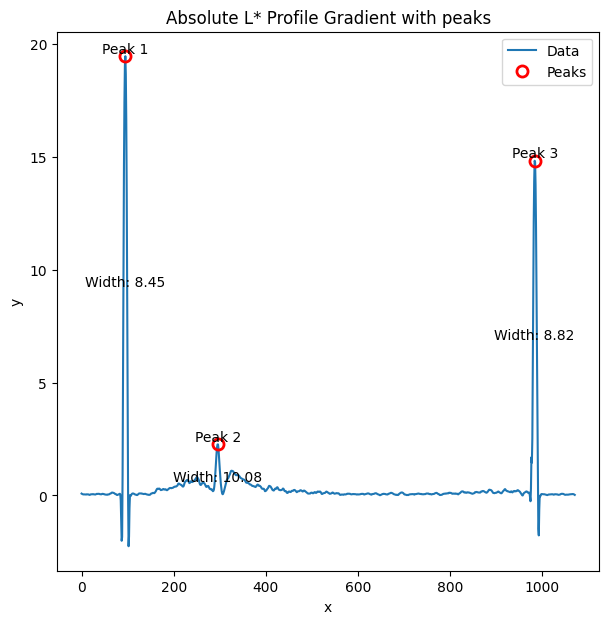

In [14]:
plot_peaks(smoothened, peaks, widths)